In [1]:
import torch
import segmentation_models_pytorch as smp
import datasets
import datetime
import numpy as np

from myUtils import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
res = 320
dataset = datasets.PlateDataset(res = res, train = True)

In [3]:
#plot_tensor(dataset[0])

In [4]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=12)

In [5]:
ENCODER = 'timm-regnetx_002'
ENCODER_WEIGHTS = 'imagenet'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=3,
    activation='sigmoid',
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [8]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)
# append to file
score = 0
optimizer.param_groups[0]['lr'] = 1e-4
for i in range(0, 150):
    print(f'\nEpoch: {i}')
    train_logs = train_epoch.run(dataloader)
    
    if train_logs['iou_score'] > score:
        torch.save(model, f'./best_model.pth')
    else:
        torch.save(model, f'./checkpoint_model.pth')

    score = train_logs['iou_score']

    with open('./train.log', 'a') as f:
        f.write(f'{i} | {datetime.datetime.now()} | {str(train_logs)}\n')

    if i == 50:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

    if i == 75:
        optimizer.param_groups[0]['lr'] = 1e-6
        print('Decrease decoder learning rate to 1e-6!')

    if i == 125:
        optimizer.param_groups[0]['lr'] = 1e-7
        print('Decrease decoder learning rate to 1e-7!')



Epoch: 0
train: 100%|██████████| 56/56 [00:26<00:00,  2.10it/s, dice_loss - 0.03971, iou_score - 0.9266]

Epoch: 1
train: 100%|██████████| 56/56 [00:25<00:00,  2.22it/s, dice_loss - 0.03972, iou_score - 0.9265]

Epoch: 2
train: 100%|██████████| 56/56 [00:25<00:00,  2.18it/s, dice_loss - 0.03867, iou_score - 0.9286]

Epoch: 3
train: 100%|██████████| 56/56 [00:25<00:00,  2.19it/s, dice_loss - 0.0384, iou_score - 0.9291] 

Epoch: 4
train: 100%|██████████| 56/56 [00:25<00:00,  2.16it/s, dice_loss - 0.03869, iou_score - 0.9286]

Epoch: 5
train: 100%|██████████| 56/56 [00:25<00:00,  2.22it/s, dice_loss - 0.03833, iou_score - 0.9292]

Epoch: 6
train: 100%|██████████| 56/56 [00:25<00:00,  2.16it/s, dice_loss - 0.03749, iou_score - 0.9306]

Epoch: 7
train: 100%|██████████| 56/56 [00:26<00:00,  2.14it/s, dice_loss - 0.03704, iou_score - 0.9315]

Epoch: 8
train: 100%|██████████| 56/56 [00:25<00:00,  2.16it/s, dice_loss - 0.03769, iou_score - 0.9303]

Epoch: 9
train: 100%|██████████| 56/56 [00:25

In [6]:
model = torch.load(f'./best_model.pth')

In [ ]:
model(dataset[0][0].reshape((1, 3, res, res)).cuda())

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 32, 1, 1])

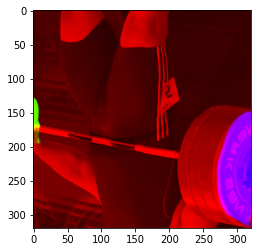

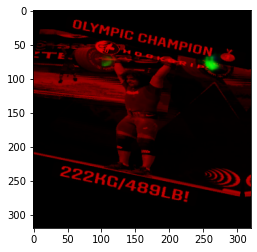

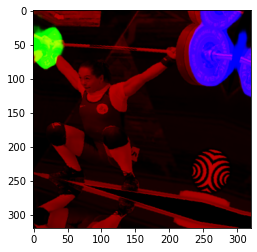

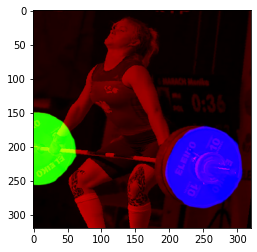

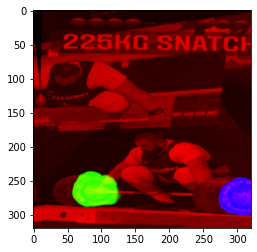

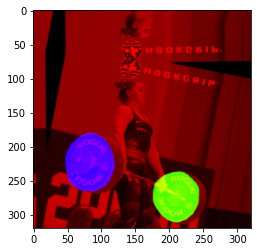

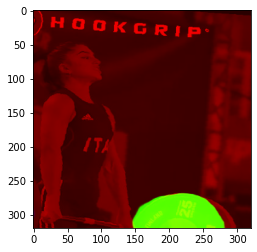

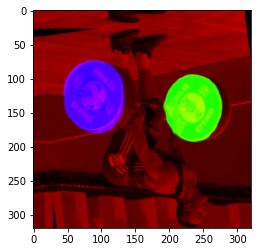

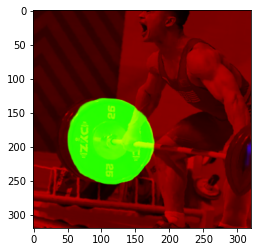

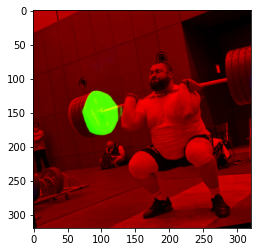

In [ ]:
for i in range(10):
    rand = np.random.randint(0, len(dataset))
    plot_pred(dataset[rand][0], model)